In [1]:
import pandas as pd
import requests
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

# Useful Links
Implementing data object for neural networks:
https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html

Writing a custom dataset class: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

Writing a GAT Class example: https://github.com/pyg-team/pytorch_geometric/blob/master/examples/gat.py

Dataloaders for Batch Training: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

Splitting datasets for training and testing: https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

Batching with GNNs: https://github.com/pyg-team/pytorch_geometric/issues/973, https://github.com/gordicaleksa/pytorch-GAT/blob/main/The%20Annotated%20GAT%20(PPI).ipynb

In [2]:
scRNA_data = pd.read_csv('GSE200981_scRNAseq_processed.tsv', sep='\t')
scRNA_data.index = scRNA_data['Gene.names']
scRNA_data = scRNA_data.drop('Gene.names', axis=1)
len(scRNA_data)

26364

In [3]:
#Mapping string to protein names
string_api_url = "https://string-db.org/api"
output_format = "tsv-no-header"
method = "get_string_ids"

params = {

    "identifiers" : "\r".join(list(scRNA_data.index)), # your protein list
    "limit": 1,
    "echo_query": 1,
    "species" : 9606, # species NCBI identifier 
    "caller_identity" : "www.awesome_app.org" # your app name

}

request_url = "/".join([string_api_url, output_format, method])

results = requests.post(request_url, data=params)


protein_2_string = dict()
string_2_protein = dict()

for line in results.text.strip().split("\n"):
    l = line.split("\t")
    protein_identifier, string_identifier = l[0], l[2]
    protein_2_string[protein_identifier] = string_identifier
    string_2_protein[string_identifier] = protein_identifier

In [4]:
scRNA_data = scRNA_data.loc[list(protein_2_string.keys())]
scRNA_data

,V1_T0,V2_T0,V3_T0,V4_T0,V5_T0,V6_T0,V7_T0,V8_T0,V9_T0,V10_T0,...,V247_T7,V248_T7,V249_T7,V250_T7,V251_T7,V252_T7,V253_T7,V254_T7,V255_T7,V256_T7
Gene.names,,,,,,,,,,,,,,,,,,,,,
OR4F5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAZ1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DAZ3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DAZ2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn as nn
from torch_geometric.data.batch import Batch
from torch_geometric.data import Data

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [7]:
%load_ext autoreload
from dataset import EMT_Dataset
dataset = EMT_Dataset(scRNA_data, string_2_protein)

  1%|          | 149713/13715404 [00:00<00:09, 1496992.23it/s]

Getting network tensor...


100%|██████████| 13715404/13715404 [00:08<00:00, 1648070.85it/s]


Getting node features tensor...


In [8]:
generator = torch.Generator().manual_seed(42)
train_length = int(0.7*len(dataset))
training_dataset, testing_dataset = random_split(dataset, [train_length, len(dataset)-train_length], generator=generator)

In [9]:
#training_loader = [Data(x=node_features, edge_index=edge_index, y=output) for node_features, edge_index, output in training_dataset]
#testing_loader = [Data(x=node_features, edge_index=edge_index, y=output) for node_features, edge_index, output in testing_dataset]

In [10]:
training_dataloader = DataLoader(training_dataset, batch_size=64, shuffle=True)
testing_dataloader = DataLoader(testing_dataset, batch_size=64, shuffle=True)

In [14]:
def GAT_train(model, dataloader, epochs, lr = 1e-8, weight_decay = 5e-4):
    torch.cuda.empty_cache()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss().to(device)
    model.train()
    optimizer.zero_grad()
    all_losses = []
    
    for _ in tqdm(range(epochs)):
        model = model.train()
        losses = []
        
        for batch in dataloader:
            node_features, graphs, outputs = batch
            for node_feature, graph, output in zip(node_features, graphs, outputs): 
                optimizer.zero_grad()
            
                graph = graph.to(device)
                node_feature = node_feature.to(device)
                output = output.to(device)
                #print(graph.size())
                out = model(node_feature, graph)
                loss = criterion(out, output)
                loss.backward()
                optimizer.step()
                losses.append(loss)
            
            all_losses.append(sum(losses)/len(losses))
        
    plt.plot([i for i in range(1, (len(all_losses)+1))], all_losses)
    plt.xlabel('Number of Batches')
    plt.ylabel('Loss')
    plt.title('GATConv E/M classification Training') 

In [15]:
%reload_ext autoreload
from GAT import GAT
model = GAT(1, dataset.num_features(), dataset.num_classes(), 1).to(device)

100%|██████████| 1000/1000 [20:40<00:00,  1.24s/it]


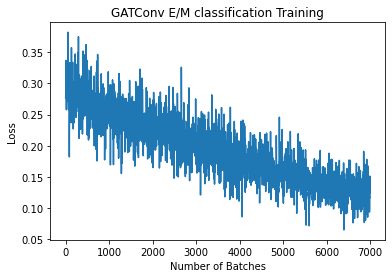

In [16]:
GAT_train(model, training_dataloader, 1000)

In [25]:
def GAT_test(model, dataloader):
    test_losses = []
    fp, tp, fn, tn = 0, 0, 0, 0
    criterion = nn.MSELoss().to(device)
    
    for batch in tqdm(dataloader):
        node_features, graphs, outputs = batch
        for node_feature, graph, output in zip(node_features, graphs, outputs):
            graph = graph.to(device)
            node_feature = node_feature.to(device)
            output = output.to(device)
        
            out = model(node_feature, graph)
            
            loss = criterion(out, output)
        
            test_losses.append(loss.item())
        
    return sum(test_losses)/len(test_losses)

In [26]:
GAT_test(model, testing_dataloader)

100%|██████████| 3/3 [00:00<00:00, 10.16it/s]


0.12795098853789208

In [ ]:
def MLP_train(model, dataloader):
    